In [ ]:
# Numerical experiment described in https://arxiv.org/pdf/2205.09322.pdf

In [1]:
using Revise
using HierarchicalDA
using LinearAlgebra
using Statistics
using Distributions
using FFTW
using BenchmarkTools

In [2]:
using CairoMakie
using LaTeXStrings

In [91]:
xlims = (0, 1)
ylims = (0, 1)

Nψ = 30
N = 101

101

In [92]:
struct PDEparams
    Nψ::Int64
    N::Int64
    xgrid::LinRange{Float64, Int64}
    ygrid::LinRange{Float64, Int64}
    xygrid::Base.Iterators.ProductIterator{Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}
    cache::Matrix{Float64}
end

function PDEparams(Nψ, N, xlims::Tuple{Real, Real}, ylims::Tuple{Real, Real})
    xgrid = LinRange(xlims[1], xlims[2], N)
    ygrid = LinRange(ylims[1], ylims[2], N)
    
    xygrid = Iterators.product(xgrid, ygrid)
    
    cache = zeros(N, N)
    return PDEparams(Nψ, N, xgrid, ygrid, xygrid, cache)
end

function pde_sol(x, y, u, params::PDEparams)
    tmp = 0.0
    for k=1:params.Nψ
        kx = k*π*x
        kxy = k*π*(x+y)
        tmp += ((sin(kx) - sin(kxy))*u[k] + (-cos(kx) + cos(kxy))*u[params.Nψ+k])/(k*π)
    end
    return cos(x+y)*exp(tmp)     
end

pde_sol (generic function with 1 method)

In [93]:
params = PDEparams(Nψ, N, xlims, ylims)

PDEparams(30, 101, LinRange{Float64}(0.0, 1.0, 101), LinRange{Float64}(0.0, 1.0, 101), Base.Iterators.ProductIterator{Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}((LinRange{Float64}(0.0, 1.0, 101), LinRange{Float64}(0.0, 1.0, 101))), [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [94]:


        
#     sin_term_x = map(k-> sin(k*π*x)/(k*π), 1:Nψ)
#     cos_term_x = map(k-> -cos(k*π*x)/(k*π), 1:Nψ)
    
#     sin_term_xy = map(k-> sin(k*π*(x+y))/(k*π), 1:Nψ)
#     cos_term_xy = map(k-> -cos(k*π*(x+y))/(k*π), 1:Nψ)

#     # Build initial condition
#     u0 = cos(x + y)

#     trig_term_x = vcat(sin_term_x, cos_term_x)
#     trig_term_xy = vcat(sin_term_xy, cos_term_xy)

#     return u0*exp(dot(trig_term_x, u) - dot(trig_term_xy, u)) 

In [95]:
ustar = zeros(2*Nψ)

ustar[1] = 0.4
ustar[3] = 0.4
ustar[6] = -0.4
ustar[Nψ+1] = -0.2
ustar[Nψ+3] = -0.4
ustar[Nψ+6] = 0.2

ustar .*= 3.0;

In [96]:

sol = zeros(N, N)
count = 0
for (j, yj) in enumerate(params.ygrid)
    for (i, xi) in enumerate(params.xgrid)
        count += 1
#         @show xi, yj, count
        sol[i,j] = pde_sol(xi, yj, ustar, params)
    end
end

sol_python = reshape(Matrix(sol'), N^2);

In [97]:
function forward!(out, u, params::PDEparams)
    for (k, xiyj) in enumerate(params.xygrid)
        xi, yj = xiyj 
#         @show xi, yj, k
        out[k] = pde_sol(xi, yj, u, params)
    end
end

forward! (generic function with 1 method)

In [98]:
grid2vec(sol) = reshape(sol, length(sol))
vec2grid(v) = reshape(v, (ceil(Int, √length(v)), ceil(Int, √length(v))))

vec2grid (generic function with 1 method)

In [99]:
out = zeros(N^2);

In [100]:
forward!(out, ustar, params)

In [101]:
isapprox(grid2vec(sol), out, atol = 100*eps())

true

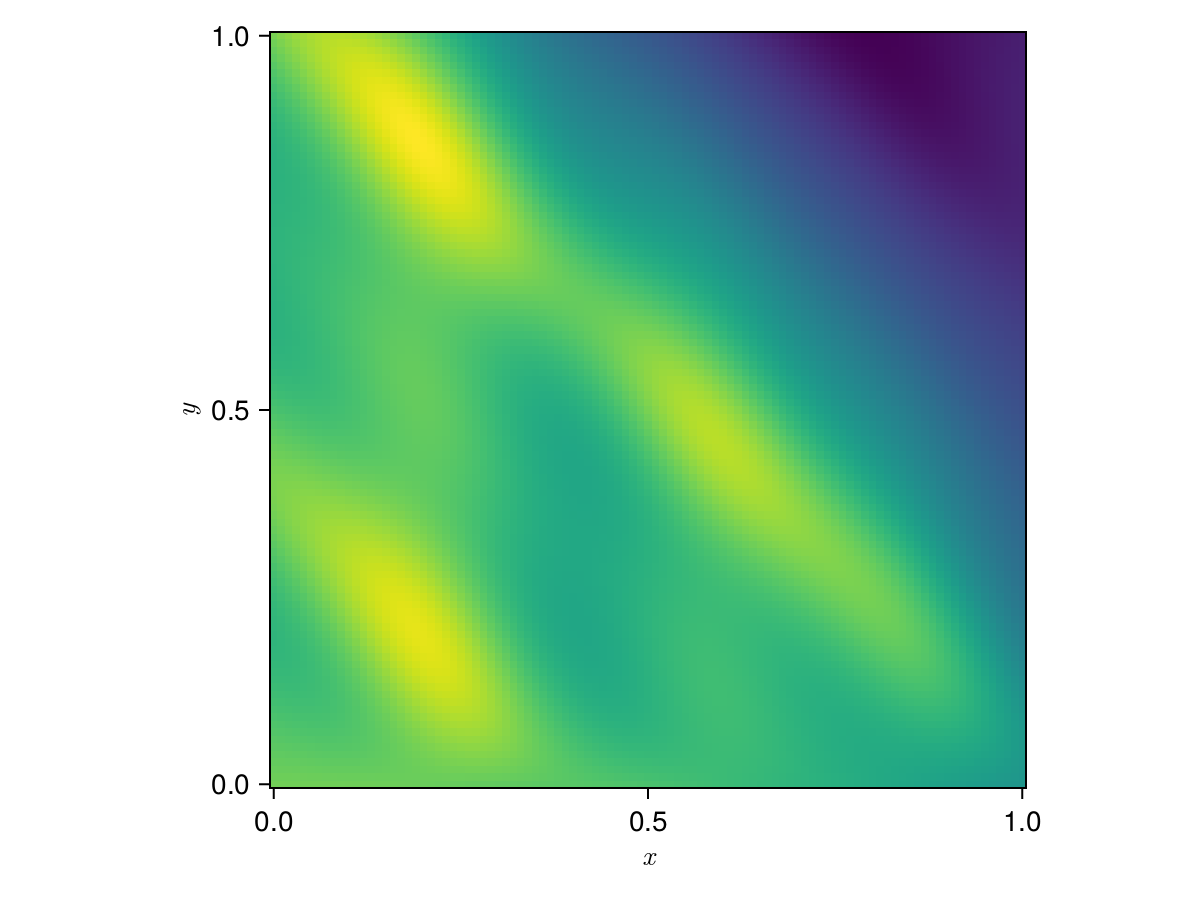

In [102]:
fig = Figure()

ax = Axis(fig[1,1], aspect = 1,
         xlabel = L"x",
         ylabel = L"y")

heatmap!(ax, params.xgrid, params.ygrid, vec2grid(out))

resize_to_layout!(fig)

fig